In [ ]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.5 MB/s eta 0:00:00


In [ ]:
# ============================
# 1. Import Necessary Libraries
# ============================
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import json
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from datetime import datetime

In [ ]:
# ============================
# 2. Load Your Data and Models
# ============================

# Load precomputed embeddings from JSON files
# Replace the file paths with your actual file locations
research_df = pd.read_json('conservation_filtered_bertopic_with_embeddings.json')
policy_df = pd.read_json('ecolex_filtered_bertopic_with_embeddings.json')

In [ ]:
# Ensure embeddings are in numpy array format
research_df['embedding'] = research_df['embedding'].apply(np.array)
policy_df['embedding'] = policy_df['embedding'].apply(np.array)

In [ ]:
research_df.columns

Index(['title', 'author', 'container-title', 'DOI', 'abstract',
       'published-online', 'topic', 'probability', 'Name', 'embedding'],
      dtype='object')

In [ ]:
print(research_df['published-online'].head())

0     {'date-parts': [[2022, 6, 15]]}
1    {'date-parts': [[2019, 11, 28]]}
2     {'date-parts': [[2015, 6, 15]]}
3     {'date-parts': [[2014, 1, 15]]}
4     {'date-parts': [[2014, 3, 15]]}
Name: published-online, dtype: object


In [ ]:
print(policy_df['date'].head())

0    2024
1    2024
2    2024
3    2024
4    2024
Name: date, dtype: int64


In [ ]:
def extract_year_from_date_parts(entry):
    if isinstance(entry, dict):
        date_parts = entry.get('date-parts')
        if date_parts and isinstance(date_parts, list) and len(date_parts) > 0:
            return date_parts[0][0]  # Extract the year (YYYY) from the first list
    return None  # Return None if the structure is invalid

In [ ]:
research_df['year'] = research_df['published-online'].apply(extract_year_from_date_parts)


In [ ]:
policy_df['year'] = policy_df['date']


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Define the embedding model and vectorizer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))

# Initialize BERTopic for research data
research_model = BERTopic(embedding_model=embedding_model, vectorizer_model=vectorizer_model)

# Fit the model on the research abstracts
research_topics, research_probs = research_model.fit_transform(research_df['abstract'].tolist())

# Save the trained research model
research_model.save("research_model")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-11-25 20:41:04,519 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
# Initialize BERTopic for policy data
policy_model = BERTopic(embedding_model=embedding_model, vectorizer_model=vectorizer_model)

# Fit the model on the policy abstracts
policy_topics, policy_probs = policy_model.fit_transform(policy_df['abstract'].tolist())

# Save the trained policy model
policy_model.save("policy_model")

2024-11-25 20:42:35,691 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [ ]:
# Load your trained BERTopic models
# Replace "your_research_model_path" and "your_policy_model_path" with actual paths
research_model = BERTopic.load("research_model")  # e.g., "research_model"
policy_model = BERTopic.load("policy_model")      # e.g., "policy_model"

In [ ]:
# Get topics and their top words for research data
research_topics_info = research_model.get_topic_info()
research_topics_info.to_csv("research_topics_info.csv", index=False)

# Get topics and their top words for policy data
policy_topics_info = policy_model.get_topic_info()
policy_topics_info.to_csv("policy_topics_info.csv", index=False)


In [ ]:
# ===============================
# 3. Define Helper Functions
# ===============================

def compute_average_embeddings(df):
    """
    Computes the average embedding for each topic in the given DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing documents with 'topic' and 'embedding' columns.

    Returns:
    - dict: A dictionary mapping each topic number to its average embedding vector.
    """
    topics = df['topic'].unique()
    average_embeddings = {}
    for topic in topics:
        if topic == -1:
            continue  # Skip outliers
        topic_docs = df[df['topic'] == topic]
        if not topic_docs.empty:
            embeddings = np.vstack(topic_docs['embedding'].values)
            average = embeddings.mean(axis=0)
            average_embeddings[topic] = average
    return average_embeddings

def map_topics_to_labels(model, average_embeddings):
    """
    Maps topic numbers to descriptive labels based on top words.

    Parameters:
    - model (BERTopic): The BERTopic model.
    - average_embeddings (dict): Dictionary of topic embeddings.

    Returns:
    - dict: Mapping of topic number to descriptive label.
    """
    topics_info = model.get_topics()
    topic_labels = {}
    for topic_num, words in topics_info.items():
        if topic_num == -1:
            continue  # Skip outliers
        top_words = ", ".join([word for word, _ in words[:5]])
        topic_labels[topic_num] = f"Topic {topic_num}: {top_words}"
    return topic_labels

In [ ]:
# ===============================
# 4. Calculate Topic-Policy Alignment
# ===============================

# Compute average embeddings for each topic
research_avg_embeddings = compute_average_embeddings(research_df)
policy_avg_embeddings = compute_average_embeddings(policy_df)

# Map topic numbers to descriptive labels
research_topic_labels = map_topics_to_labels(research_model, research_avg_embeddings)
policy_topic_labels = map_topics_to_labels(policy_model, policy_avg_embeddings)

# Create DataFrames from average embeddings
research_emb_df = pd.DataFrame.from_dict(research_avg_embeddings, orient='index')
policy_emb_df = pd.DataFrame.from_dict(policy_avg_embeddings, orient='index')

# Calculate cosine similarity between research and policy topics
similarity_matrix = cosine_similarity(research_emb_df, policy_emb_df)
similarity_df = pd.DataFrame(similarity_matrix, index=research_emb_df.index, columns=policy_emb_df.index)

# Align each research topic to the most similar policy topic
alignment = similarity_df.idxmax(axis=1)       # Aligned Policy Topic Number
alignment_scores = similarity_df.max(axis=1)  # Similarity Scores

# Create a mapping DataFrame
topic_alignment = pd.DataFrame({
    'Research_Topic_Num': similarity_df.index,
    'Aligned_Policy_Topic_Num': alignment,
    'Similarity_Score': alignment_scores
})

# Map topic numbers to labels
topic_alignment['Research_Topic_Label'] = topic_alignment['Research_Topic_Num'].map(research_topic_labels)
topic_alignment['Aligned_Policy_Topic_Label'] = topic_alignment['Aligned_Policy_Topic_Num'].map(policy_topic_labels)

# Save alignment results
topic_alignment.to_csv('topic_policy_alignment.csv', index=False)
print("Topic-Policy Alignment saved to 'topic_policy_alignment.csv'.")

Topic-Policy Alignment saved to 'topic_policy_alignment.csv'.


In [ ]:
# ===============================
# Calculate Novelty/Innovation Scores
# ===============================

cutoff_date_research = pd.Timestamp('2022-01-01')  # Modify as needed
cutoff_date_policy = 2022  # Policy data only has years

# Use the existing splitting logic for research and policy DataFrames
# Research DataFrame split by 'published-online' column
research_past = research_df[research_df['year'] < cutoff_date_research.year]
research_recent = research_df[research_df['year'] >= cutoff_date_research.year]

# Policy DataFrame split by 'year' column
policy_past = policy_df[policy_df['year'] < cutoff_date_policy]
policy_recent = policy_df[policy_df['year'] >= cutoff_date_policy]

# Compute average embeddings for past and recent periods
research_past_avg = compute_average_embeddings(research_past)
research_recent_avg = compute_average_embeddings(research_recent)
policy_past_avg = compute_average_embeddings(policy_past)
policy_recent_avg = compute_average_embeddings(policy_recent)

# Function to calculate novelty scores
def calculate_novelty_scores(past_avg, recent_avg, source_label, topic_labels):
    """
    Calculate novelty scores by comparing past and recent embeddings.

    Parameters:
    - past_avg (dict): Average embeddings for past topics.
    - recent_avg (dict): Average embeddings for recent topics.
    - source_label (str): Label for source ('Research' or 'Policy').
    - topic_labels (dict): Dictionary mapping topic numbers to labels.

    Returns:
    - dict: A dictionary mapping topics to novelty scores.
    """
    novelty_scores = {}
    for topic_num, recent_emb in recent_avg.items():
        past_emb = past_avg.get(topic_num)
        if past_emb is not None:
            similarity = cosine_similarity([recent_emb], [past_emb])[0][0]
            novelty_scores[f"{source_label} Topic {topic_num}: {topic_labels.get(topic_num, 'Unknown')}"] = 1 - similarity
        else:
            novelty_scores[f"{source_label} Topic {topic_num}: {topic_labels.get(topic_num, 'Unknown')}"] = None  # No past data
    return novelty_scores

# Calculate novelty scores for research and policy data
research_novelty = calculate_novelty_scores(research_past_avg, research_recent_avg, 'Research', research_topic_labels)
policy_novelty = calculate_novelty_scores(policy_past_avg, policy_recent_avg, 'Policy', policy_topic_labels)

# Combine novelty scores into one dictionary
novelty_scores = {**research_novelty, **policy_novelty}

# Convert novelty scores to DataFrame
novelty_df = pd.DataFrame(list(novelty_scores.items()), columns=['Topic', 'Novelty_Score'])
novelty_df = novelty_df.dropna()  # Remove topics with None scores
novelty_df = novelty_df.sort_values(by='Novelty_Score', ascending=False)




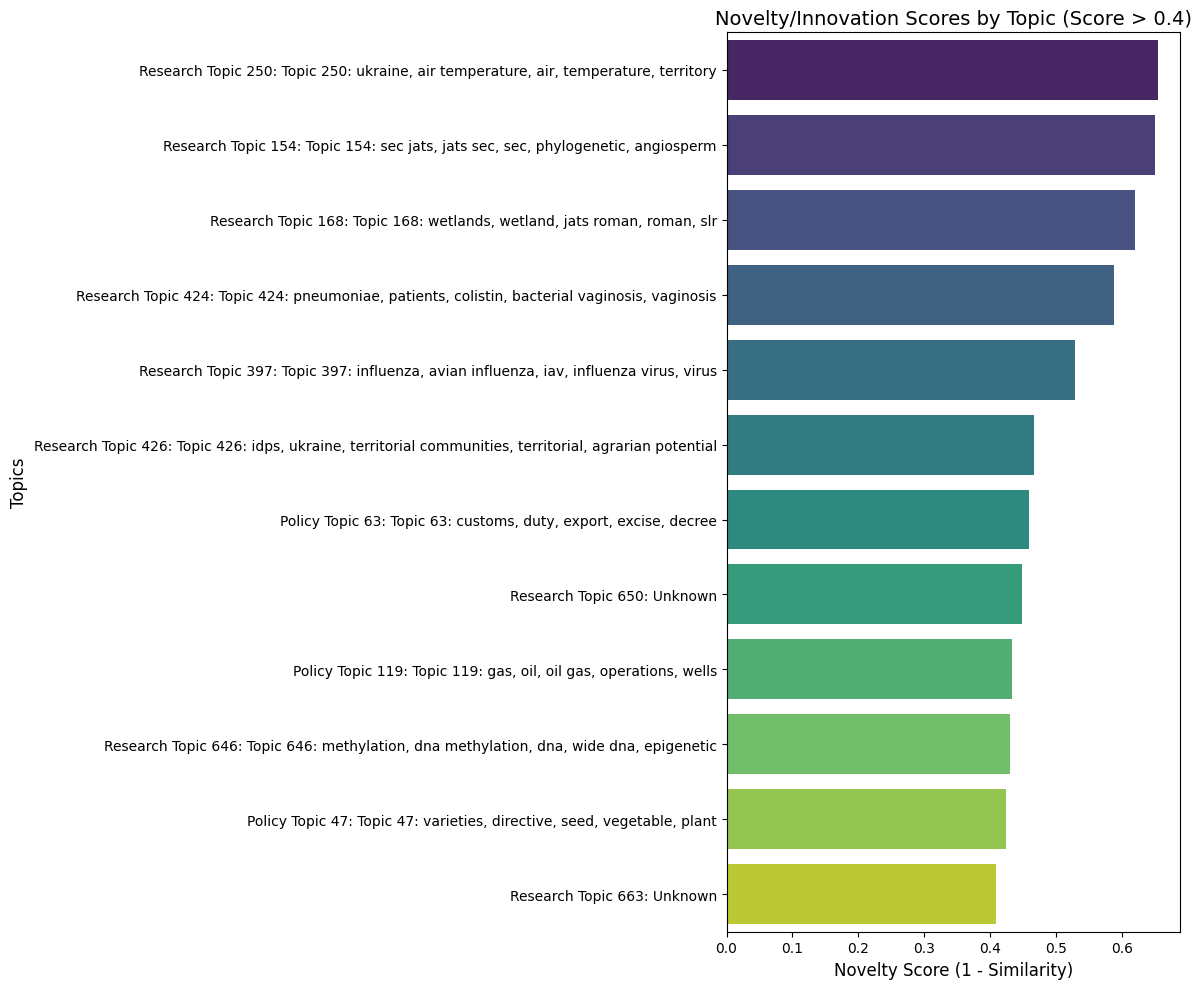

In [ ]:
# ===============================
# Visualize Novelty Scores
# ===============================

# Set a threshold for filtering novelty scores
novelty_threshold = 0.4  # Include topics with novelty scores > 0.2
filtered_novelty_df = novelty_df[novelty_df['Novelty_Score'] > novelty_threshold]

# Create a bar chart for filtered novelty scores
plt.figure(figsize=(12, 10))
sns.barplot(
    x='Novelty_Score',
    y='Topic',
    data=filtered_novelty_df,
    palette='viridis'
)
plt.title(f'Novelty/Innovation Scores by Topic (Score > {novelty_threshold})', fontsize=14)
plt.xlabel('Novelty Score (1 - Similarity)', fontsize=12)
plt.ylabel('Topics', fontsize=12)
plt.tight_layout()

# Save the filtered bar chart
plt.savefig('filtered_novelty_scores_bar.png')

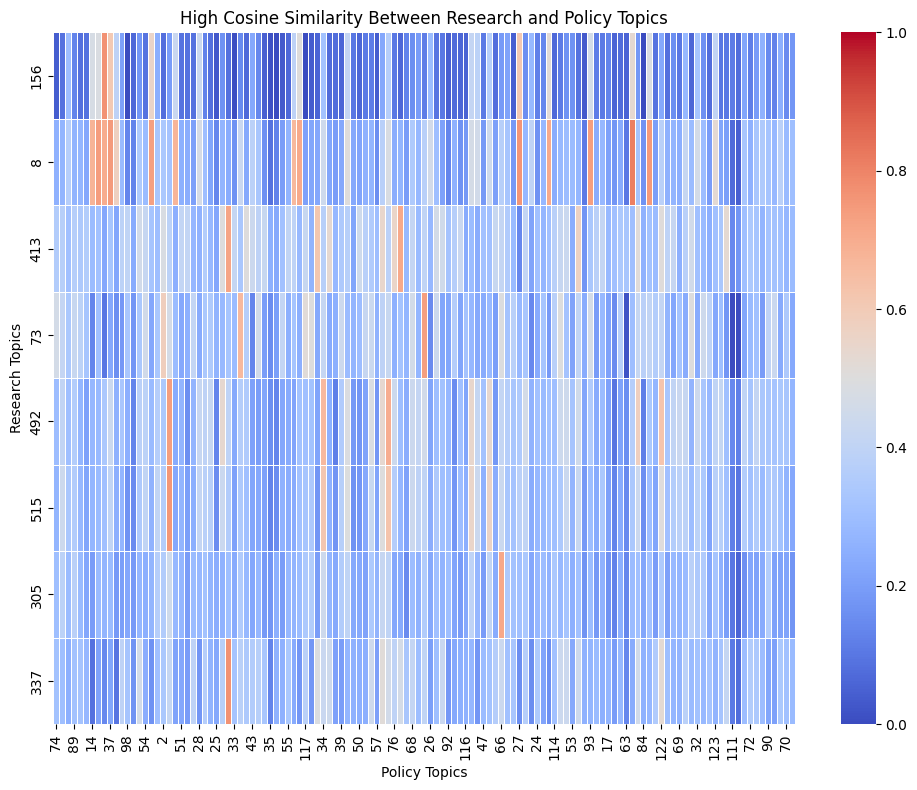

In [ ]:
# Filter for high similarities
high_similarity_df = similarity_df[similarity_df.max(axis=1) > 0.7]  # Adjust threshold as needed
plt.figure(figsize=(10, 8))
sns.heatmap(high_similarity_df, annot=False, cmap='coolwarm', vmin=0, vmax=1, linewidths=0.5)
plt.title('High Cosine Similarity Between Research and Policy Topics')
plt.xlabel('Policy Topics')
plt.ylabel('Research Topics')
plt.tight_layout()
plt.savefig('topic_similarity_heatmap.png')


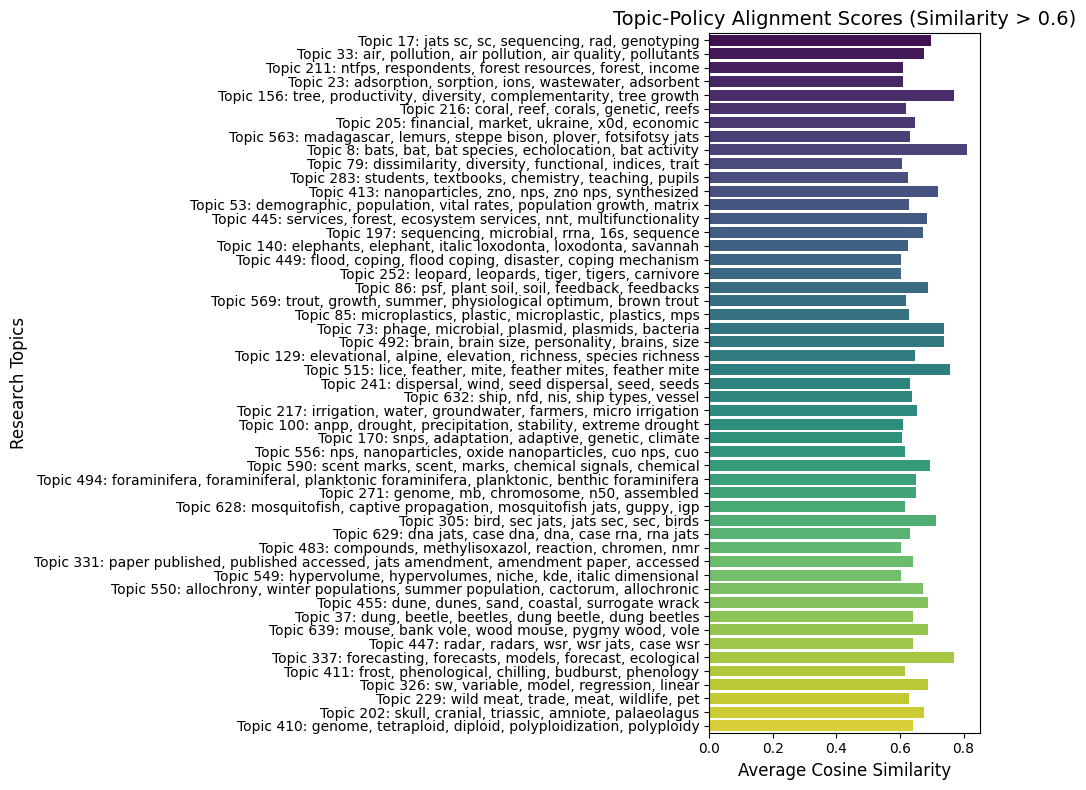

In [ ]:
# Set threshold for filtering significant alignments
threshold = 0.6  # Adjust as needed

# Filter for alignments with similarity scores above the threshold
filtered_topic_alignment = topic_alignment[topic_alignment['Similarity_Score'] > threshold]

# Create the bar chart
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Similarity_Score',
    y='Research_Topic_Label',
    data=filtered_topic_alignment,
    palette='viridis'
)
plt.title(f'Topic-Policy Alignment Scores (Similarity > {threshold})', fontsize=14)
plt.xlabel('Average Cosine Similarity', fontsize=12)
plt.ylabel('Research Topics', fontsize=12)
plt.tight_layout()

# Save the bar chart
plt.savefig('filtered_topic_policy_alignment_bar.png')

In [ ]:
# Set the similarity threshold (same as the bar chart)
threshold = 0.6

# Load the topic_policy_alignment.csv file
topic_alignment = pd.read_csv('topic_policy_alignment.csv')

# Filter for significant alignments based on the threshold
filtered_alignment = topic_alignment[topic_alignment['Similarity_Score'] > threshold]

# Save to a new CSV for easier inspection
filtered_alignment.to_csv('filtered_topic_policy_alignment.csv', index=False)
print("Filtered topic-policy alignment saved to 'filtered_topic_policy_alignment.csv'.")

Filtered topic-policy alignment saved to 'filtered_topic_policy_alignment.csv'.


In [ ]:
# ===============================
# 6. Visualization
# ===============================

# D. Interactive Network Graph for Topic-Policy Alignment
# Create a similarity threshold for edges
similarity_threshold = 0.5  # Adjust as needed

# Initialize graph
G = nx.Graph()

# Add nodes and edges based on similarity threshold
for _, row in topic_alignment.iterrows():
    research_topic = row['Research_Topic_Label']
    policy_topic = row['Aligned_Policy_Topic_Label']
    similarity = row['Similarity_Score']

    # Add nodes with attributes
    G.add_node(research_topic, type='Research', label=research_topic)
    G.add_node(policy_topic, type='Policy', label=policy_topic)

    # Add edge if similarity meets threshold
    if similarity >= similarity_threshold:
        G.add_edge(research_topic, policy_topic, weight=similarity)

# Validate that there are edges in the graph
if G.number_of_edges() == 0:
    print(f"No edges meet the similarity threshold of {similarity_threshold}.")
else:
    # Generate positions for the graph layout
    pos = nx.spring_layout(G, seed=42)

    # Extract edge information for visualization
    edge_x = []
    edge_y = []
    edge_text = []  # Tooltips for edges

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_text.append(f"Similarity: {edge[2]['weight']:.2f}")

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',  # Optional: Change to 'text' if you want edge tooltips
        mode='lines'
    )

    # Extract node information for visualization
    node_x = []
    node_y = []
    node_text = []
    node_color = []

    for node in G.nodes(data=True):
        x, y = pos[node[0]]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node[1]['label'])
        # Assign colors based on node type
        node_color.append('blue' if node[1]['type'] == 'Research' else 'red')

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',  # Remove visible labels
        hoverinfo='text',  # Enable hover-only labels
        text=node_text,   # Full labels available on hover
        marker=dict(
            size=10,
            color=node_color,
            line=dict(width=2)
        )
    )

    # Create the final Plotly graph
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Network Graph for Topic-Policy Alignment',
                        titlefont=dict(size=16),
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=40),
                        xaxis=dict(showgrid=False, zeroline=False),
                        yaxis=dict(showgrid=False, zeroline=False)
                    ))

    # Show or save the interactive graph
    fig.show()
    fig.write_html('topic_policy_network.html')
    print("Interactive Network Graph saved to 'topic_policy_network.html'.")


Interactive Network Graph saved to 'topic_policy_network.html'.
